In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd
import uuid
import torch

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Step 1: Define System and Simulation Parameters
N = 64  # Number of BS antennas
K = 4   # Number of users
M = 4   # Number of RF chains
omega = 0.3  # Tradeoff weight

I_max = 120  # Maximum outer iterations
sigma_n2 = 1.0  # Noise variance
mu = 0.01  # Step size for analog precoder
lambda_ = 0.01  # Step size for digital precoder
L = 20  # Number of paths for channel

# Convert to tensors
omega_t = torch.tensor(omega, dtype=torch.float32, device=device)
sigma_n2_t = torch.tensor(sigma_n2, dtype=torch.float32, device=device)
mu_t = torch.tensor(mu, dtype=torch.float32, device=device)
lambda_t = torch.tensor(lambda_, dtype=torch.float32, device=device)

# Step 2: Define Sensing Parameters
P = 3  # Number of desired sensing angles
theta_d = np.array([-60, 0, 60]) * np.pi / 180  # Desired angles in radians
delta_theta = 5 * np.pi / 180  # Half beamwidth
theta_grid = np.linspace(-np.pi / 2, np.pi / 2, 181)  # Angular grid [-90, 90] degrees
B_d = np.zeros(len(theta_grid))  # Desired beampattern
for t, theta_t in enumerate(theta_grid):
    for theta_p in theta_d:
        if abs(theta_t - theta_p) <= delta_theta:
            B_d[t] = 1

# Convert to tensors
theta_d_t = torch.tensor(theta_d, dtype=torch.float32, device=device)
theta_grid_t = torch.tensor(theta_grid, dtype=torch.float32, device=device)
B_d_t = torch.tensor(B_d, dtype=torch.float32, device=device)

# Wavenumber and antenna spacing
lambda_wave = 1  # Wavelength (normalized)
k = 2 * np.pi / lambda_wave
d = lambda_wave / 2  # Antenna spacing

k_t = torch.tensor(k, dtype=torch.float32, device=device)
d_t = torch.tensor(d, dtype=torch.float32, device=device)

In [2]:
import h5py
SNR_dB_array = np.arange(0, 12.1, 0.1)
# Load Psi data (from MATLAB .mat file)
with h5py.File('Psi_all.mat', 'r') as f:
    Psi_h5 = f['Psi_all']

    # If stored as MATLAB complex structure (real/imag parts separate)
    if np.issubdtype(Psi_h5.dtype, np.void):
        real = Psi_h5['real'][()]
        imag = Psi_h5['imag'][()]
        Psi_all = real + 1j * imag
    else:
        Psi_all = np.array(Psi_h5)

# Ensure Psi_all has shape: (num_SNRs, M, N)
Psi_all = np.squeeze(Psi_all)  # remove singleton dimensions if any


def compute_psi(snr_db):
    """
    Selects the Psi matrix corresponding to the closest SNR value.
    """
    # Find index of closest SNR
    idx = np.argmin(np.abs(SNR_dB_array - snr_db))

    # Select corresponding Psi
    Psi = Psi_all[idx, :, :]

    return Psi


===== Initialization: Proposed =====
  → Running for J = 10
    ✓ Averaged over 10 realizations

===== Initialization: Random =====
  → Running for J = 10
    ✓ Averaged over 10 realizations

===== Initialization: Random =====
  → Running for J = 10
    ✓ Averaged over 10 realizations

===== Initialization: SVD =====
  → Running for J = 10
    ✓ Averaged over 10 realizations

===== Initialization: SVD =====
  → Running for J = 10
    ✓ Averaged over 10 realizations
    ✓ Averaged over 10 realizations


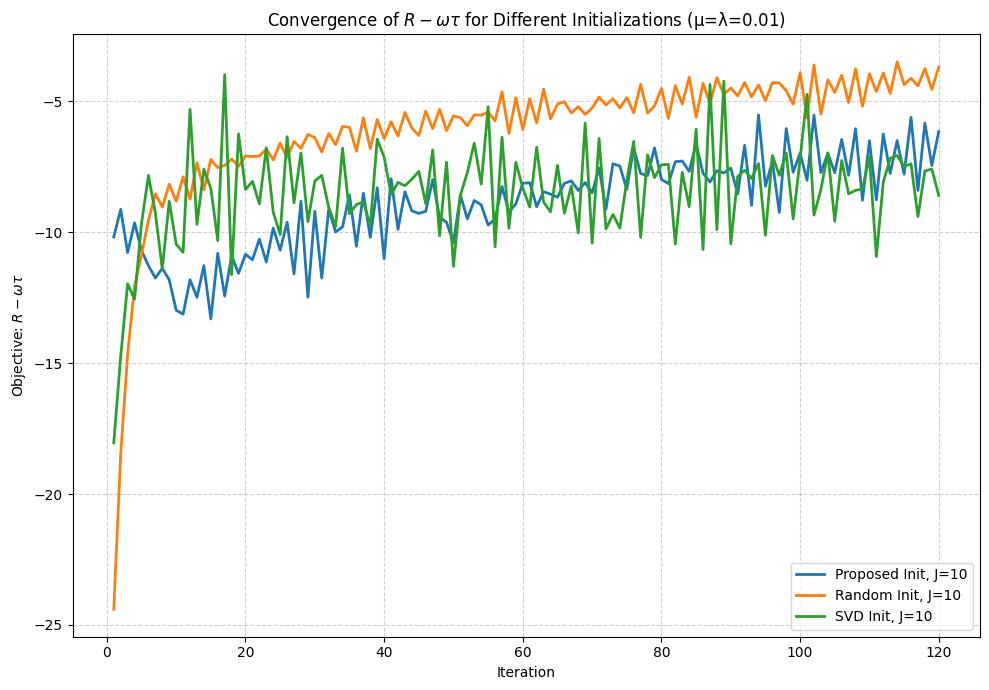

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from lib.support_functions_torch import generate_channel_torch, run_pga_torch, proposed_initialization_torch, random_initialization_torch, svd_initialization_torch
# === Initialization methods to test ===
init_methods = {
    "Proposed": proposed_initialization_torch,
    "Random": random_initialization_torch,
    "SVD": svd_initialization_torch
}

J_list = [10]  # Different inner iteration counts
num_realizations = 10
snr_db = 12
snr_linear = 10 ** (snr_db / 10)
P_BS = snr_linear * sigma_n2
# Convert P_BS to PyTorch tensor
P_BS = torch.tensor(P_BS, dtype=torch.float32, device=device)
Psi = compute_psi(snr_db)
# Convert Psi to PyTorch tensor with correct dtype
Psi = torch.tensor(Psi, dtype=torch.complex64, device=device)

# === Storage for results ===
R_omega_tau_results = {init: {J: np.zeros(I_max) for J in J_list} for init in init_methods}

# === Main Experiment ===
for init_name, init_func in init_methods.items():
    print(f"\n===== Initialization: {init_name} =====")
    for J in J_list:
        print(f"  → Running for J = {J}")
        for realization in range(num_realizations):
            H = generate_channel_torch(N, M, L, device, k_t, d_t)
            if init_name == "Proposed":
                A0, D0 = init_func(H, theta_d, N, M, K, P_BS, device)
            elif init_name == "Random":
                A0, D0 = init_func(N, M, H, P_BS, device)
            elif init_name == "SVD":
                A0, D0 = init_func(H, N, M, K, P_BS, device)
            else:
                raise ValueError("Unknown initialization type.")

            R_omega_tau, A, D = run_pga_torch(H, A0, D0, J=J, I_max=I_max,
                                  mu=mu, lambda_=lambda_, omega=omega,
                                  sigma_n2=sigma_n2, Psi=Psi, P_BS=P_BS, device=device)
            R_omega_tau_results[init_name][J] += R_omega_tau

        # Average across all realizations
        R_omega_tau_results[init_name][J] /= num_realizations
        print(f"    ✓ Averaged over {num_realizations} realizations")

# === Plot Results ===
plt.figure(figsize=(10, 7))
for init_name in init_methods.keys():
    for J in J_list:
        plt.plot(range(1, I_max + 1),
                 R_omega_tau_results[init_name][J],
                 linewidth=2,
                 label=f'{init_name} Init, J={J}')

plt.xlabel('Iteration')
plt.ylabel(r'Objective: $R - \omega \tau$')
plt.title(r'Convergence of $R - \omega \tau$ for Different Initializations (μ=λ=0.01)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()
